## TMDB Score Prediction and Movie Recommendation



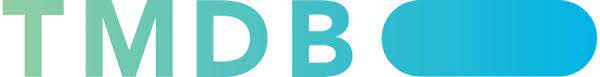

### Recommendation systems are becoming increasingly important in today’s hectic world. People are always in the lookout for products/services that are best suited for them. Therefore, the recommendation systems are important as they help them make the right choices, without having to expend their cognitive resources.

### In this kernel, I will build a Movie Recommendation System using collaborative filtering by implementing the K-Nearest Neighbors algorithm. I will also predict the rating of the given movie based on its neighbors and compare it with the actual rating.

### Check out my [blog](https://medium.com/swlh/movie-recommendation-and-rating-prediction-using-k-nearest-neighbors-704ca8ccaff3) for a better understanding 

### **Import the required Python libraries**

In [97]:
import pandas as pd
import seaborn as sns
import numpy as np
import json
import warnings
import base64
import io
from scipy import spatial
from matplotlib.pyplot import imread
import codecs
from IPython.display import HTML
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

### **Import the dataset**

In [98]:
movies_tmdb = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
credits = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
movies_movielens=pd.read_csv('/kaggle/input/movie-lens-100k/movies.csv')
ratings_movielens=pd.read_csv('/kaggle/input/movie-lens-100k/ratings.csv')

## **Data Exploration & Cleaning**

In [99]:
movies_movielens.columns = ['movieId','title','genre']


In [100]:
ratings_movielens.columns=['userId','movieId','rating','timestamp']

In [101]:
ratings_movielens.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [102]:
unique_user_ids=ratings_movielens['userId'].unique()
len(unique_user_ids)

671

**Converting JSON into strings**

In [103]:
#Changing the column Data from json to string format
movies_tmdb['genres'] = movies_tmdb['genres'].apply(json.loads)
for index,i in zip(movies_tmdb.index,movies_tmdb['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies_tmdb.loc[index,'genres'] = str(list1)

movies_tmdb['keywords'] = movies_tmdb['keywords'].apply(json.loads)
for index,i in zip(movies_tmdb.index,movies_tmdb['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies_tmdb.loc[index,'keywords'] = str(list1)
    
movies_tmdb['production_companies'] = movies_tmdb['production_companies'].apply(json.loads)
for index,i in zip(movies_tmdb.index,movies_tmdb['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies_tmdb.loc[index,'production_companies'] = str(list1)


credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast'] = str(list1)
 
credits['crew'] = credits['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
credits['crew'] = credits['crew'].apply(director)
credits.rename(columns={'crew':'director'},inplace=True)

### **Merging the two csv files**

In [104]:
movies_tmdb = movies_tmdb.merge(credits,left_on='id',right_on='movie_id',how='left')
movies_tmdb = movies_tmdb[['id','original_title','genres','cast','vote_average','director','keywords']]

In [105]:
duplicate_values = movies_tmdb.duplicated(subset='original_title', keep=False)

# Filter the DataFrame to keep only rows with unique values in the specified column
movies_tmdb = movies_tmdb[~duplicate_values]


In [106]:
duplicate_values = movies_movielens.duplicated(subset='title', keep=False)

# Filter the DataFrame to keep only rows with unique values in the specified column
movies_movielens = movies_movielens[~duplicate_values]


In [107]:
movies_tmdb['original_title'] = movies_tmdb['original_title'].astype(str).str.lower().str.replace(' ', '')
movies_movielens['title'] = movies_movielens['title'].astype(str).str.lower().str.replace(' ', '')

In [108]:
movies_movielens['title']=movies_movielens.title.str.replace('(\(\d\d\d\d\))','',regex=True)
movies_movielens['title']=movies_movielens['title'].apply(lambda x:x.strip())

In [109]:
common_rows = movies_tmdb[movies_tmdb['original_title'].isin(movies_movielens['title'].tolist())]

# Get the number of common rows
num_common_rows = len(common_rows)
common_rows.shape

(2554, 7)

In [110]:
movies = pd.merge(movies_tmdb, movies_movielens, how='inner', left_on='original_title', right_on='title')
movies = movies.drop(['title'], axis=1)
movies = movies.drop(['genre'], axis=1)

In [111]:
duplicate_values = movies.duplicated(subset='original_title', keep=False)

# Filter the DataFrame to keep only rows with unique values in the specified column
movies = movies[~duplicate_values]

In [112]:
ratings_movielens=pd.merge(ratings_movielens, movies_movielens, how='inner', left_on='movieId', right_on='movieId')


In [113]:
ratings_movielens=ratings_movielens[ratings_movielens['title'].isin(movies_tmdb['original_title'].tolist())]


In [114]:
ratings_movielens=ratings_movielens.drop(['timestamp','genre'],axis=1)


## **Working with the Genres column**

In [115]:
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

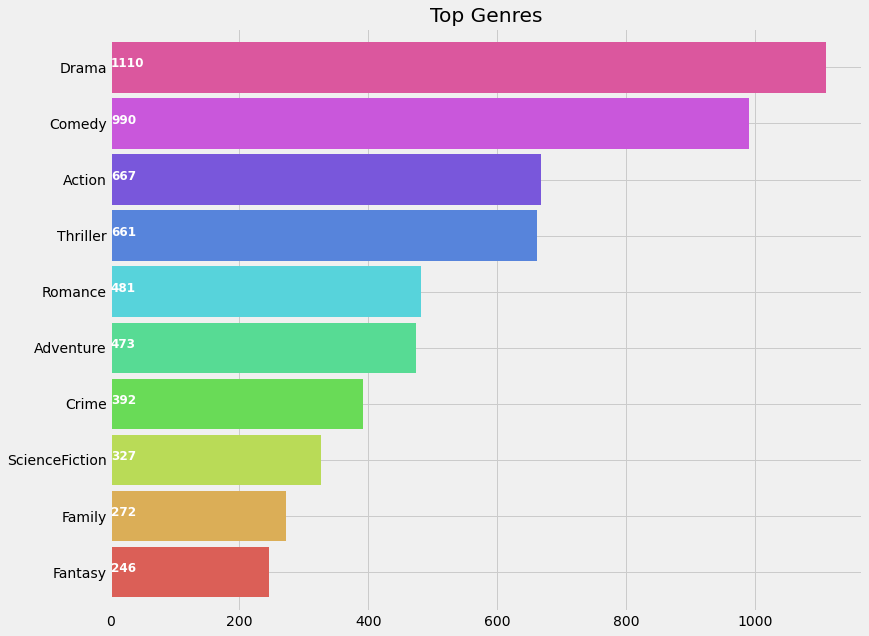

In [116]:
plt.subplots(figsize=(12,10))
list1 = []
for i in movies['genres']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Genres')
plt.show()

Drama appears to be the most popular genre followed by Comedy.

In [117]:
for i,j in zip(movies['genres'],movies.index):
    list2=[]
    list2=i
    list2.sort()
    movies.loc[j,'genres']=str(list2)
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

Now lets generate a list 'genreList' with all possible unique genres mentioned in the dataset.



In [118]:
genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)
genreList[:10] #now we have a list with unique genres

['Action',
 'Adventure',
 'Fantasy',
 'ScienceFiction',
 'Crime',
 'Animation',
 'Family',
 'Thriller',
 'Comedy',
 'Drama']

**One Hot Encoding for multiple labels**

In [119]:
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [120]:
movies['genres_bin'] = movies['genres'].apply(lambda x: binary(x))
movies['genres_bin'].head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

## **Working with the Cast Column**
 

In [121]:
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['cast'] = movies['cast'].str.split(',')

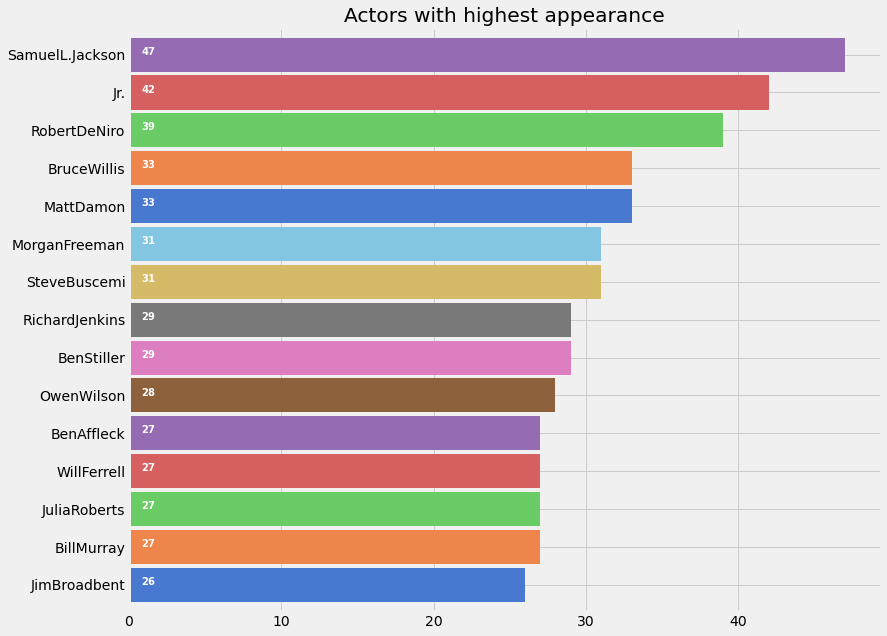

In [122]:
plt.subplots(figsize=(12,10))
list1=[]
for i in movies['cast']:
    list1.extend(i)
ax=pd.Series(list1).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(pd.Series(list1).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='white',weight='bold')
plt.title('Actors with highest appearance')
plt.show()

In [123]:
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i[:4]
    movies.loc[j,'cast'] = str(list2)
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['cast'] = movies['cast'].str.split(',')
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'cast'] = str(list2)
movies['cast']=movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')

In [124]:
castList = []
for index, row in movies.iterrows():
    cast = row["cast"]
    
    for i in cast:
        if i not in castList:
            castList.append(i)

In [125]:
def binary(cast_list):
    binaryList = []
    
    for genre in castList:
        if genre in cast_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [126]:
movies['cast_bin'] = movies['cast'].apply(lambda x: binary(x))
movies['cast_bin'].head()

0    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...
2    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
3    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...
4    [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Name: cast_bin, dtype: object

## **Working with Director column**

In [127]:
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)

In [128]:
movies.head()

,id,original_title,genres,cast,vote_average,director,keywords,movieId,genres_bin,cast_bin
0,19995,avatar,"[Action, Adventure, Fantasy, ScienceFiction]","SamWorthington,SigourneyWeaver,StephenLang,Zoe...",7.2,James Cameron,"['culture clash', 'future', 'space war', 'spac...",72998,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,285,piratesofthecaribbean:atworld'send,"[Action, Adventure, Fantasy]","JohnnyDepp,KeiraKnightley,OrlandoBloom,Stellan...",6.9,Gore Verbinski,"['ocean', 'drug abuse', 'exotic island', 'east...",53125,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
2,206647,spectre,"[Action, Adventure, Crime]","ChristophWaltz,DanielCraig,LéaSeydoux,RalphFie...",6.3,Sam Mendes,"['spy', 'based on novel', 'secret agent', 'seq...",136020,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,49529,johncarter,"[Action, Adventure, ScienceFiction]","LynnCollins,SamanthaMorton,TaylorKitsch,Willem...",6.1,Andrew Stanton,"['based on novel', 'mars', 'medallion', 'space...",93363,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ..."
4,559,spider-man3,"[Action, Adventure, Fantasy]","JamesFranco,KirstenDunst,ThomasHadenChurch,Tob...",5.9,Sam Raimi,"['dual identity', 'amnesia', 'sandstorm', ""lov...",52722,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


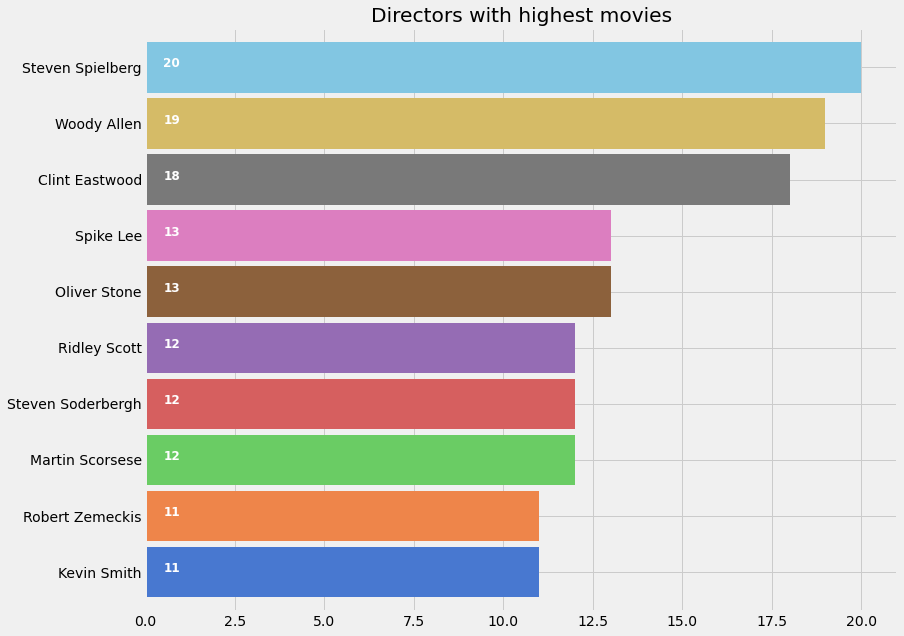

In [129]:
plt.subplots(figsize=(12,10))
ax = movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(movies[movies['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

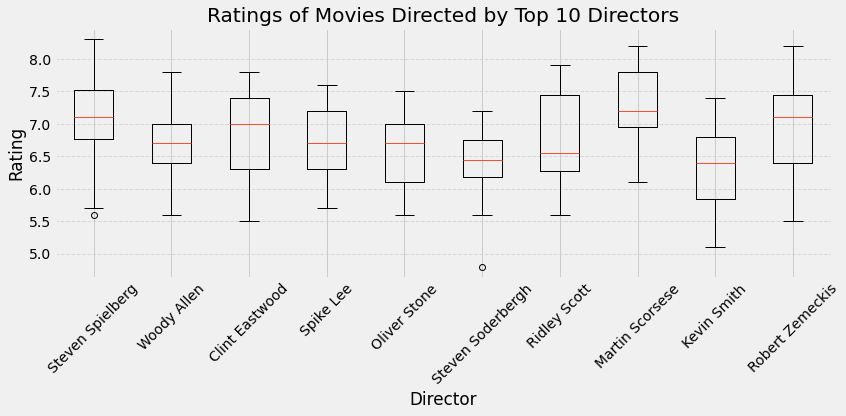

In [130]:
director_movie_counts = movies['director'].value_counts()
top_10_directors = director_movie_counts.head(10).index

# Filter the data to include only movies directed by the top 10 directors
filtered_df = movies[movies['director'].isin(top_10_directors)]

#Printin BoxPlot
plt.figure(figsize=(12, 6))
plt.boxplot([filtered_df[filtered_df['director'] == director]['vote_average'] for director in top_10_directors], labels=top_10_directors)
plt.title('Ratings of Movies Directed by Top 10 Directors')
plt.xlabel('Director')
plt.ylabel('Rating')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [131]:
directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)

In [132]:
def binary(director_list):
    binaryList = []  
    for direct in directorList:
        if direct in director_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [133]:
movies['director_bin'] = movies['director'].apply(lambda x: binary(x))


In [134]:
MLmovie=pd.read_csv('/kaggle/input/movie-lens-100k/movies.csv')
move3 = pd.merge(MLmovie[['movieId', 'title']], movies, on='movieId')
movies=move3
movies.head()

,movieId,title,id,original_title,genres,cast,vote_average,director,keywords,genres_bin,cast_bin,director_bin
0,1,Toy Story (1995),862,toystory,"[Animation, Comedy, Family]","DonRickles,JimVarney,TimAllen,TomHanks",7.7,John Lasseter,"['jealousy', 'toy', 'boy', 'friendship', 'frie...","[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,10,GoldenEye (1995),710,goldeneye,"[Action, Adventure, Thriller]","FamkeJanssen,IzabellaScorupco,PierceBrosnan,Se...",6.6,Martin Campbell,"['cuba', 'falsely accused', 'secret identity',...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,14,Nixon (1995),10858,nixon,"[Drama, History]","AnthonyHopkins,EdHarris,JoanAllen,PowersBoothe",7.1,Oliver Stone,"['usa president', 'presidential election', 'wa...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,Cutthroat Island (1995),1408,cutthroatisland,"[Action, Adventure]","FrankLangella,GeenaDavis,MatthewModine,MauryCh...",5.7,Renny Harlin,"['exotic island', 'treasure', 'map', 'ship', '...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,16,Casino (1995),524,casino,"[Crime, Drama]","JamesWoods,JoePesci,RobertDeNiro,SharonStone",7.8,Martin Scorsese,"['poker', 'drug abuse', '1970s', 'overdose', '...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## **Working with the Keywords column**

In [135]:
movies.drop(columns=['original_title'],inplace=True)
movies.rename(columns={"title_x": "original_title"}, inplace=True)

In [136]:
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

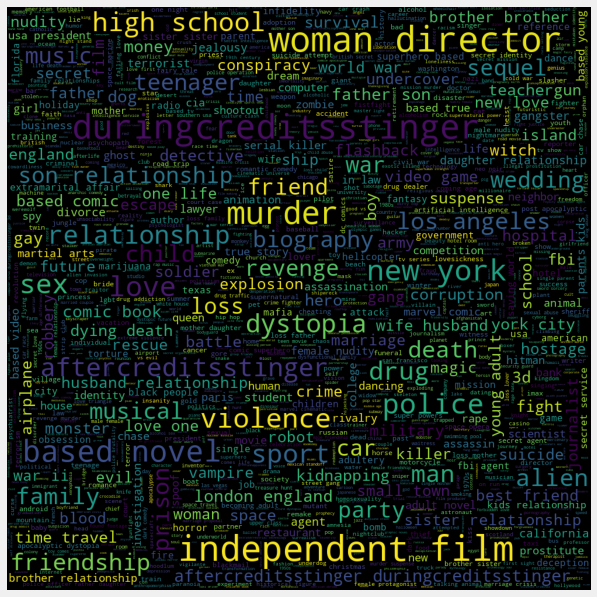

In [137]:
plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies['keywords'].dropna().apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS, max_font_size= 60,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()
#This will print a wordcloud showing the major keywords or tags used for describing the movies.

In [138]:
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')

In [139]:
words_list = []
for index, row in movies.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

In [140]:
def binary(words):
    binaryList = []
    for genre in words_list:
        if genre in words:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [141]:
movies['words_bin'] = movies['keywords'].apply(lambda x: binary(x))
movies = movies[(movies['vote_average']!=0)] #removing the movies with 0 score and without drector names 
movies = movies[movies['director']!='']

In [142]:
#We will we using Cosine Similarity for finding the similarity between 2 movies.
def Similarity(movieId1, movieId2):
    a = movies.iloc[movieId1]
    b = movies.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['cast_bin']
    scoreB = b['cast_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['words_bin']
    wordsB = b['words_bin']
    wordsDistance = spatial.distance.cosine(directA, directB)
    return genreDistance + directDistance + scoreDistance + wordsDistance

In [143]:
new_id = list(range(0,movies.shape[0]))
movies['new_id']=new_id
movies.rename(columns={"title": "original_title"}, inplace=True)
movies=movies[['original_title','genres','vote_average','genres_bin','cast_bin','new_id','director','director_bin','words_bin']]
#movies.shape

## **Score Predictor**

In [144]:
import operator

def KNN_predict_score():
    name = input('Enter a movie title: ')
    new_movie = movies[movies['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0])
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in movies.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)
    sigm = 0
    mae=0
    print('\nMovies Recommended based on K-Nearest Neighbors Content based filtering:')
    for neighbor in neighbors:
        avgRating = avgRating+movies.iloc[neighbor[0]][2] 
        mae+= abs(float(new_movie['vote_average'])-float(movies.iloc[neighbor[0]][2]))
        sigm += pow(float(new_movie['vote_average'])-float(movies.iloc[neighbor[0]][2]),2)
        print( movies.iloc[neighbor[0]][0])
    
    print('\n')
    avgRating = avgRating/K
    sigm = (sigm/K)**(0.5)
    mae = mae/K
    
    print('Root mean squared error for KNN Content Based Filtering =',sigm)
    print('Mean Absolute Error for KNN Content Based Filtering =',mae)
   

In [145]:

KNN_predict_score()


Enter a movie title:  Pi


Selected Movie:  Pinocchio (1940)

Movies Recommended based on K-Nearest Neighbors Content based filtering:
Madagascar 3: Europe's Most Wanted (2012)
Bambi (1942)
Meet the Deedles (1998)
Mulan (1998)
Doug's 1st Movie (1999)
Space Jam (1996)
Fantasia 2000 (1999)
Antz (1998)
Snow White and the Seven Dwarfs (1937)
Pocahontas (1995)


Root mean squared error for KNN Content Based Filtering = 1.0890362712049586
Mean Absolute Error for KNN Content Based Filtering = 0.7200000000000001
